In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [2]:
device='cpu'

In [3]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['Road Construction and Management','Waste Management','Electricity Department','Nature and Recreation Department','Water Supply and Management']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [5]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [6]:
train_dir = 'complaint_dataset/train'
test_dir = 'complaint_dataset/test'

In [7]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


In [8]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Coul

In [9]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

/Users/amanrev/Documents/project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 10%|█         | 1/10 [00:53<08:01, 53.50s/it]

Epoch: 1 | train_loss: 1.5883 | train_acc: 0.2598 | test_loss: 1.2689 | test_acc: 0.6000


 20%|██        | 2/10 [01:43<06:51, 51.47s/it]

Epoch: 2 | train_loss: 1.1868 | train_acc: 0.5990 | test_loss: 1.0282 | test_acc: 0.8000


 30%|███       | 3/10 [02:34<05:57, 51.05s/it]

Epoch: 3 | train_loss: 0.9060 | train_acc: 0.7964 | test_loss: 0.8714 | test_acc: 0.8000


 40%|████      | 4/10 [03:42<05:48, 58.06s/it]

Epoch: 4 | train_loss: 0.7098 | train_acc: 0.9216 | test_loss: 0.7383 | test_acc: 0.8000


 50%|█████     | 5/10 [04:34<04:38, 55.67s/it]

Epoch: 5 | train_loss: 0.5608 | train_acc: 0.9688 | test_loss: 0.6267 | test_acc: 1.0000


 60%|██████    | 6/10 [05:26<03:37, 54.34s/it]

Epoch: 6 | train_loss: 0.4494 | train_acc: 0.9688 | test_loss: 0.5343 | test_acc: 1.0000


 70%|███████   | 7/10 [06:14<02:37, 52.43s/it]

Epoch: 7 | train_loss: 0.3616 | train_acc: 0.9841 | test_loss: 0.4688 | test_acc: 1.0000


 80%|████████  | 8/10 [07:03<01:42, 51.16s/it]

Epoch: 8 | train_loss: 0.2975 | train_acc: 0.9841 | test_loss: 0.4167 | test_acc: 0.8000


 90%|█████████ | 9/10 [08:34<01:03, 63.62s/it]

Epoch: 9 | train_loss: 0.2494 | train_acc: 0.9922 | test_loss: 0.3768 | test_acc: 0.8000


100%|██████████| 10/10 [09:28<00:00, 56.82s/it]

Epoch: 10 | train_loss: 0.2128 | train_acc: 1.0000 | test_loss: 0.3465 | test_acc: 0.8000


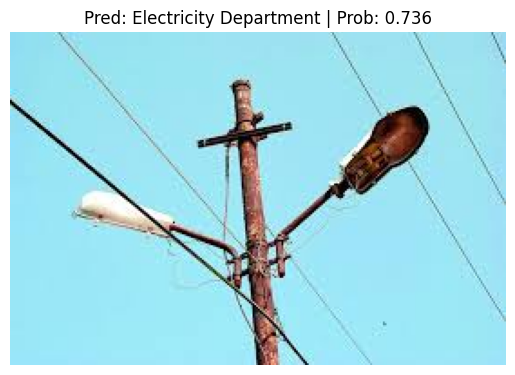

In [10]:

import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "complaint_dataset/test/Electricity Department/download.jpeg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

